<a href="https://colab.research.google.com/github/lauramsromano/categorization_vendas/blob/colab/Aplica%C3%A7%C3%A3o_Regress%C3%A3o_Logistica%2C_KNN_e_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Base - https://archive.ics.uci.edu/dataset/352/online+retail

Queremos brever `churn`, ou seja, se o cliente irá cancelar ou não a sua compra.


In [ ]:
# bibliotecas padrões:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# divisão treino e teste e validação cruzada:
from sklearn.model_selection import (cross_validate,
                                     StratifiedKFold,
                                     train_test_split)

# modelos de categorização e métrica:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# pipeline:
from sklearn.pipeline import Pipeline # gerando pipeline
from sklearn.pipeline import make_pipeline # extraindo infos da pipeline
from sklearn.compose import ColumnTransformer # agrupação de métodos para pipeline

# processamento de variáveis numéricas:
from sklearn.preprocessing import RobustScaler # ajuste da escala das features

# processamento de variáveis nominais:
!pip install category_encoders
from category_encoders import CountEncoder # transformação por frequencia
from sklearn.impute import SimpleImputer #

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# leitura da base
amostra = pd.read_excel('online_retail.xlsx')
amostra

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Glossário de features já existentes na base:
- `InvoiceNo`: Número da fatura: número integral de 6 dígitos atribuído exclusivamente a cada transação.
Se este código começar com a letra 'c', indica um cancelamento.
- `StockCode`: Código do produto: um número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.
- `Description`: Nome do produto.
-` Quantity`: As quantidades de cada produto (item) por transação.
- `InvoiceDate`: Dia e a hora em que cada transação foi gerada.
- `UnitPrice`: Preço do produto por unidade em libras esterlinas.
- `CustomerID`: Número integral de 5 dígitos atribuído exclusivamente a cada cliente.
- `Country`: Nome do país onde cada cliente reside.

In [ ]:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Verificando valores ausentes:
amostra.isna().sum() / amostra.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [ ]:
# Verificando proporção de infos por pais:
amostra['Country'].value_counts() / len(amostra)*100

United Kingdom          91.431956
Germany                  1.752139
France                   1.579047
EIRE                     1.512431
Spain                    0.467422
Netherlands              0.437527
Belgium                  0.381798
Switzerland              0.369435
Portugal                 0.280305
Australia                0.232327
Norway                   0.200403
Italy                    0.148180
Channel Islands          0.139876
Finland                  0.128250
Cyprus                   0.114779
Sweden                   0.085254
Unspecified              0.082302
Austria                  0.073998
Denmark                  0.071783
Japan                    0.066063
Poland                   0.062926
Israel                   0.054806
USA                      0.053699
Hong Kong                0.053145
Singapore                0.042258
Iceland                  0.033585
Canada                   0.027864
Greece                   0.026942
Malta                    0.023436
United Arab Em

In [ ]:
# Verificando os anos presente na base:
amostra['InvoiceDate'].dt.year.unique()

array([2010, 2011])

In [ ]:
# Verificando a quantidade de itens:
amostra['StockCode'].nunique()

4070

Preparação da base para aplicação dos modelos:
- **Tratamento e criação** das **features**.
- **Definição** da **target**.
- Filtro de data para **definição de período de análise**.

In [ ]:
# Convertendo a coluna 'CustomerID' em string:
amostra['CustomerID'] = amostra['CustomerID'].astype(str)

In [ ]:
# Adicionar aleatoriamente a letra 'c' na coluna 'InvoiceNo' para termos informações de cancelamentos:
indices_cancelados = random.sample(range(len(amostra)), int(len(amostra) * 0.2)) # 20% das transações serão canceladas
amostra.loc[indices_cancelados, 'InvoiceNo'] = 'c' + amostra.loc[indices_cancelados, 'InvoiceNo'].astype(str)

amostra[amostra['InvoiceNo'].apply(lambda x: str(x).startswith('c'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4,c536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,c536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
11,c536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
17,c536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom
21,c536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,c581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541894,c581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France
541897,c581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09 12:50:00,3.75,12680.0,France
541904,c581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France


In [ ]:
# Criando coluna 'Status' para pontuar os cancelamentos:
amostra['Status'] = amostra['InvoiceNo'].apply(lambda x: 'Cancelado' if str(x).startswith('c') else 'Não Cancelado')
amostra[['Status', 'InvoiceNo']]

,Status,InvoiceNo
0,Não Cancelado,536365
1,Não Cancelado,536365
2,Não Cancelado,536365
3,Não Cancelado,536365
4,Cancelado,c536365
...,...,...
541904,Cancelado,c581587
541905,Não Cancelado,581587
541906,Cancelado,c581587
541907,Não Cancelado,581587


<Axes: >

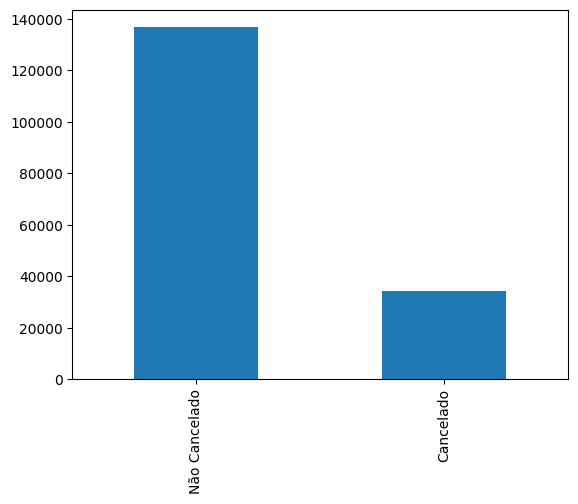

In [ ]:
# Proporção da target:
amostra['Status'].value_counts().plot(kind = 'bar')

In [ ]:
round(amostra['Status'].value_counts() / len(amostra)*100, 2)

Não Cancelado    79.99
Cancelado        20.01
Name: Status, dtype: float64

In [ ]:
# Cálculo do preço total da transação:
amostra['TotalPrice'] = amostra['Quantity'] * amostra['UnitPrice']
amostra['TotalPrice']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: TotalPrice, Length: 541909, dtype: float64

In [ ]:
# Definir a data limite como dezembro de 2011
data_limite = pd.to_datetime('2011-12-01')

# Filtrar os registros dos últimos 3 meses
amostra = amostra[amostra['InvoiceDate'] >= data_limite - pd.DateOffset(months=2)]

# Exibir os registros filtrados
amostra['InvoiceDate'].dt.month.unique()

array([10, 11, 12])

In [ ]:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170978 entries, 370931 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    170978 non-null  object        
 1   StockCode    170978 non-null  object        
 2   Description  170784 non-null  object        
 3   Quantity     170978 non-null  int64         
 4   InvoiceDate  170978 non-null  datetime64[ns]
 5   UnitPrice    170978 non-null  float64       
 6   CustomerID   170978 non-null  object        
 7   Country      170978 non-null  object        
 8   Status       170978 non-null  object        
 9   TotalPrice   170978 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 14.3+ MB


Separação das features e aplicação dos modelos.
- Criação da **pipeline** para tratamento das features.

In [ ]:
# Separando variáveis categóricas e numéricas:
cat_features = amostra.select_dtypes('object').drop(columns = 'Status').columns.to_list()
num_features = amostra.select_dtypes(exclude = 'object').columns.to_list()

cat_features, num_features

(['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country'],
 ['Quantity', 'InvoiceDate', 'UnitPrice', 'TotalPrice'])

In [ ]:
# Divisão em dados de treino e de teste:

X = amostra.drop(columns = ['Status'])
y = amostra.Status

In [ ]:
SEED = 546744165

# separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = SEED,
                                                    stratify = y)